# Consensus Mouse: 10X gene expression

In the [previous notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html), we explored the taxonomy and combined it with cell level and other metadata. In this notebook, we load and explore gene expression data, loading the expression of specific genes. We plot these expressions in the heatmaps, comparing the expression across the taxonomy and parcellation region, as well as show the gene expression in the UMAP.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Optional

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you would like to download the data to your system.**

In [2]:
download_base = Path('../data/allen-brain-cell-atlas-staging')
abc_cache = AbcProjectCache.from_local_cache(
    download_base,
)

abc_cache.current_manifest

/opt/conda/lib/python3.9/site-packages/abc_atlas_access/abc_atlas_cache/cloud_cache.py:519: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. Unless running as a LocalCache, files will be re-downloaded.
  warnings.warn(msg, MissingLocalManifestWarning)
/opt/conda/lib/python3.9/site-packages/abc_atlas_access/abc_atlas_cache/cloud_cache.py:1490: ReadOnlyLocalCacheWarning: LocalCache is a read only directory and cannot
                save the last used manifest.
                Current Manifest: releases/20251031/manifest.json
  warnings.warn(


'releases/20251031/manifest.json'

Below we create the expanded cell metadata as was done previously in the [cluster annotation tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html) tutorial.

In [3]:
cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    'Consensus-Mouse-taxonomy', 'cell_to_cluster_membership'
).set_index('cell_label')
cluster = abc_cache.get_metadata_dataframe(
    'Consensus-Mouse-taxonomy', 'cluster'
).set_index('label')
cluster_annotation_term = abc_cache.get_metadata_dataframe(
    'Consensus-Mouse-taxonomy', 'cluster_annotation_term'
).set_index('label')

cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-taxonomy',
    file_name='cluster_annotation_term_set'
).set_index('label')

cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
).set_index('cluster_annotation_term_label')

macosko_cell_metadata = abc_cache.get_metadata_dataframe('Consensus-Mouse-Macosko-10X', 'cell_metadata').set_index('cell_label')
wmb_cell_metadata = abc_cache.get_metadata_dataframe('Consensus-Mouse-WMB-10X', 'cell_metadata').set_index('cell_label')

membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(
    cluster.reset_index().set_index('cluster_alias')[['number_of_cells']],
    on='cluster_alias'
)

membership_with_cluster_info = membership_with_cluster_info.join(cluster_annotation_term, rsuffix='_anno_term').reset_index()

membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)

cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['neighborhood', 'class', 'subclass', 'supertype', 'cluster'], inplace=True)

cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(
    ['neighborhood', 'class', 'subclass', 'supertype', 'cluster'],
    inplace=True
)

wmb_cell_extended = wmb_cell_metadata.join(cell_to_cluster_membership, how='inner')
wmb_cell_extended = wmb_cell_extended.join(cluster_details, on='cluster_alias')
wmb_cell_extended = wmb_cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
wmb_cell_extended = wmb_cell_extended.join(cluster_order, on='cluster_alias', rsuffix='_order')

wmb_library = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-WMB-10X',
    file_name='library'
).set_index('library_label')
wmb_donor = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-WMB-10X',
    file_name='donor'
).set_index('donor_label')
wmb_cell_extended = wmb_cell_extended.join(wmb_library, on='library_label')
wmb_cell_extended = wmb_cell_extended.join(wmb_donor, on='donor_label')

macosko_cell_extended = macosko_cell_metadata.join(cell_to_cluster_membership, how='inner')
macosko_cell_extended = macosko_cell_extended.join(cluster_details, on='cluster_alias')
macosko_cell_extended = macosko_cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
macosko_cell_extended = macosko_cell_extended.join(cluster_order, on='cluster_alias', rsuffix='_order')

macosko_library = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-Macosko-10X',
    file_name='library'
).set_index('library_label')
macosko_donor = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-Macosko-10X',
    file_name='donor'
).set_index('donor_label')
macosko_cell_extended = macosko_cell_extended.join(macosko_library, on='library_label')
macosko_cell_extended = macosko_cell_extended.join(macosko_donor, on='donor_label')

### Single cell transcriptomes

Below we use the convenience function `get_gene_data` to download and extract specific genes from the gene expression h5ad files. This function can be used to pull expression for the full set of cells or any subset from the set of cell metadata.

We first load the gene data for the WMB portion of the consensus dataset.

In [4]:
wmb_gene = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(wmb_gene))
wmb_gene.head(5)

Number of aligned genes =  32285


gene_symbol                               name  \
gene_identifier                                                     
ENSMUSG00000051951        Xkr4  X-linked Kx blood group related 4   
ENSMUSG00000089699      Gm1992                predicted gene 1992   
ENSMUSG00000102331     Gm19938              predicted gene, 19938   
ENSMUSG00000102343     Gm37381              predicted gene, 37381   
ENSMUSG00000025900         Rp1     retinitis pigmentosa 1 (human)   

                   mapped_ncbi_identifier comment  
gene_identifier                                    
ENSMUSG00000051951        NCBIGene:497097     NaN  
ENSMUSG00000089699                    NaN     NaN  
ENSMUSG00000102331                    NaN     NaN  
ENSMUSG00000102343                    NaN     NaN  
ENSMUSG00000025900         NCBIGene:19888     NaN

Next we load the same metadata for the Macosko data. Note that the two samples have slightly different sets of genes, however, they have a large overlap. 

In [5]:
macosko_gene = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-Macosko-10X',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(macosko_gene))
macosko_gene.head(5)

Number of aligned genes =  21205


gene_symbol
gene_identifier               
ENSMUSG00000072572     Slc39a2
ENSMUSG00000063179        Pstk
ENSMUSG00000041220      Elovl6
ENSMUSG00000042246        Tmc7
ENSMUSG00000075072      Olfr48

Below we list the genes we will use in this notebook and the example method used to load the expression for these specific genes from the h5ad file. Note that we provide a set of example gene expressions as a csv file for brevity in this tutorial. To process and extract the gene expressions for yourself, uncomment the code block below. More details on how to extract specific genes from the data see our [accessing gene expression data tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html)

In [6]:
gene_names = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc18a3', 'Slc6a3', 'Slc6a4', 'Slc6a2']
"""
wmb_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=wmb_cell_metadata,
    all_genes=wmb_gene,
    selected_genes=gene_names
)
"""

'\nwmb_gene_data = get_gene_data(\n    abc_atlas_cache=abc_cache,\n    all_cells=wmb_cell_metadata,\n    all_genes=wmb_gene,\n    selected_genes=gene_names\n)\n'

In [7]:
"""
macosko_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=macosko_cell_metadata,
    all_genes=macosko_gene,
    selected_genes=gene_names
)"""

'\nmacosko_gene_data = get_gene_data(\n    abc_atlas_cache=abc_cache,\n    all_cells=macosko_cell_metadata,\n    all_genes=macosko_gene,\n    selected_genes=gene_names\n)'

Instead of processing the gene expressions, we load a pre-processed file.

In [8]:
macosko_gene_data = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-Macosko-10X',
    file_name='example_gene_expression'
).set_index('cell_label')
wmb_gene_data = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-WMB-10X',
    file_name='example_gene_expression'
).set_index('cell_label')

We load merge the expression into each of our cell metadata.

In [9]:
wmb_cell_extended = wmb_cell_extended.join(wmb_gene_data)
macosko_cell_extended = macosko_cell_extended.join(macosko_gene_data)

## Example use cases

In this section, we show a use case plotting a set of genes that map onto a cononical set of neurotransmitters. These are the same set genes used in the [WMB tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/10x_snRNASeq_tutorial_part_2b.html).

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [10]:
import matplotlib as mpl

def plot_heatmap(
    df: pd.DataFrame,
    gnames: List[str],
    value: str,
    sort: bool = False,
    fig_width: float = 8,
    fig_height: float = 4,
    vmax: float = None,
    cmap: plt.cm = plt.cm.magma
):
    """Plot a heatmap of gene expression values for a list of genes across species.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell metadata and gene expression values.
    gnames : list
        List of gene names to plot.
    value : str
        Column name in df to group by (e.g., 'species_genus').
    sort : bool, optional
        Whether to sort the gene expression values within each species.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    vmax : float, optional
        Maximum value for the color scale. If None, it is set to the maximum value in the data.
    cmap : matplotlib colormap, optional
        Colormap to use for the heatmap.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the heatmap.
    ax : array of matplotlib.axes.Axes
        The axes objects for each species.
    """

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_width, fig_height)

    grouped = df.groupby(value)[gnames].mean()
    vmin = grouped.min().min()
    vmax = grouped.max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
        grouped = grouped.loc[sorted(grouped.index)]

    arr = grouped.to_numpy().astype('float')

    ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = grouped.columns.values
    ylabs = grouped.index.values


    ax.set_yticks(range(len(ylabs)))
    ax.set_yticklabels(ylabs)
    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('Mean Expression [log2(CPM + 1)]')
    plt.subplots_adjust(wspace=0.00, hspace=0.00)
    
    return fig, ax

### Average expression of selected genes

Below we plot the expression of the genes we selected  averaged across metadata terms in a heatmap. We show these by neighborhood for each experiment/dataset individually and then togegether.

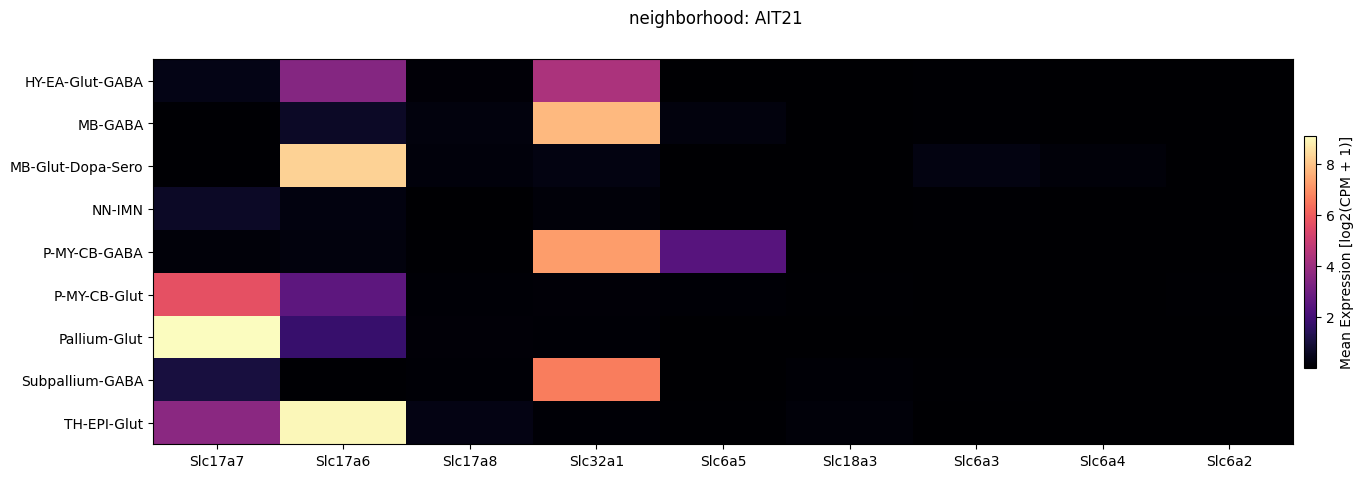

In [11]:
fig, ax = plot_heatmap(
    df=wmb_cell_extended,
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: AIT21')
plt.show()

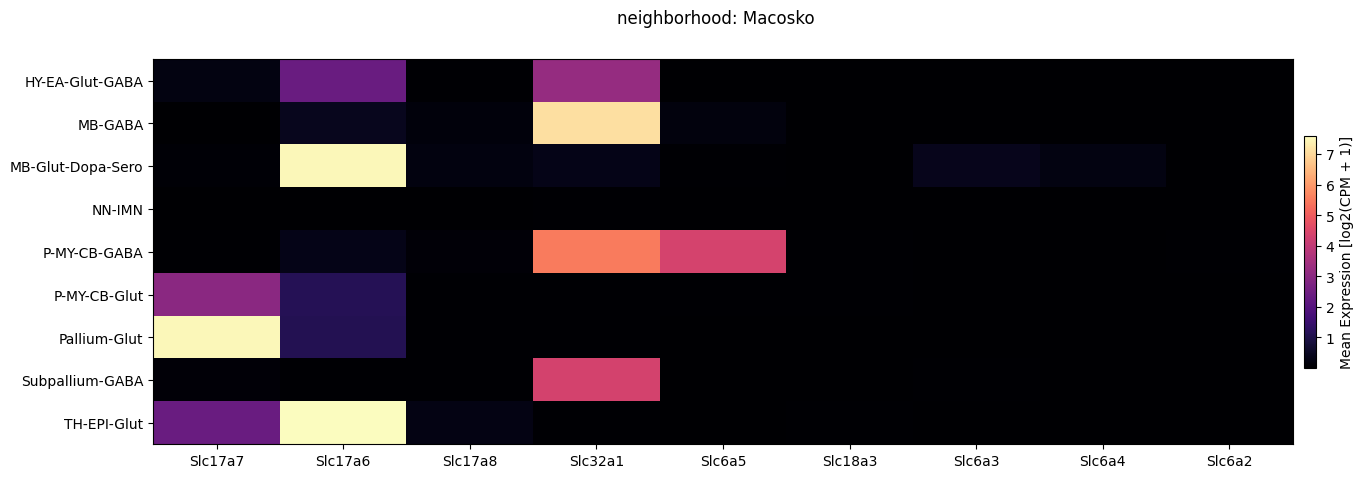

In [12]:
fig, ax = plot_heatmap(
    df=macosko_cell_extended,
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: Macosko')
plt.show()

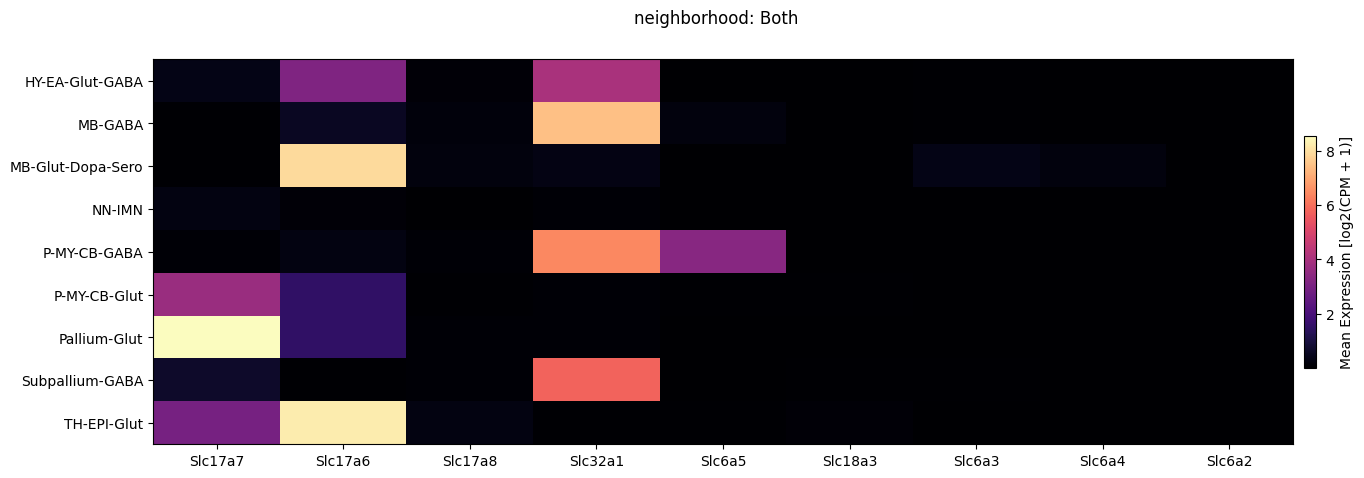

In [13]:
fig, ax = plot_heatmap(
    df=pd.concat([wmb_cell_extended, macosko_cell_extended]),
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: Both')
plt.show()

Next we show the selected genes by neurotransmitter for both datasets.

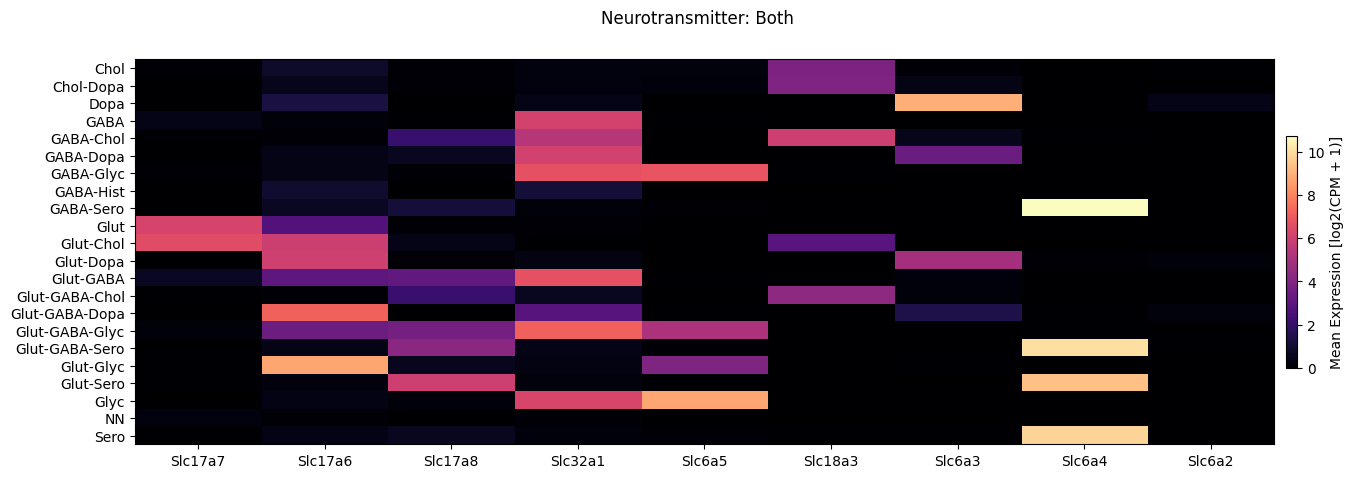

In [14]:
fig, ax = plot_heatmap(
    df=pd.concat([wmb_cell_extended, macosko_cell_extended]),
    gnames=gene_names,
    value='neurotransmitter',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('Neurotransmitter: Both')
plt.show()

Finally, we break down the expression by parcellation term.

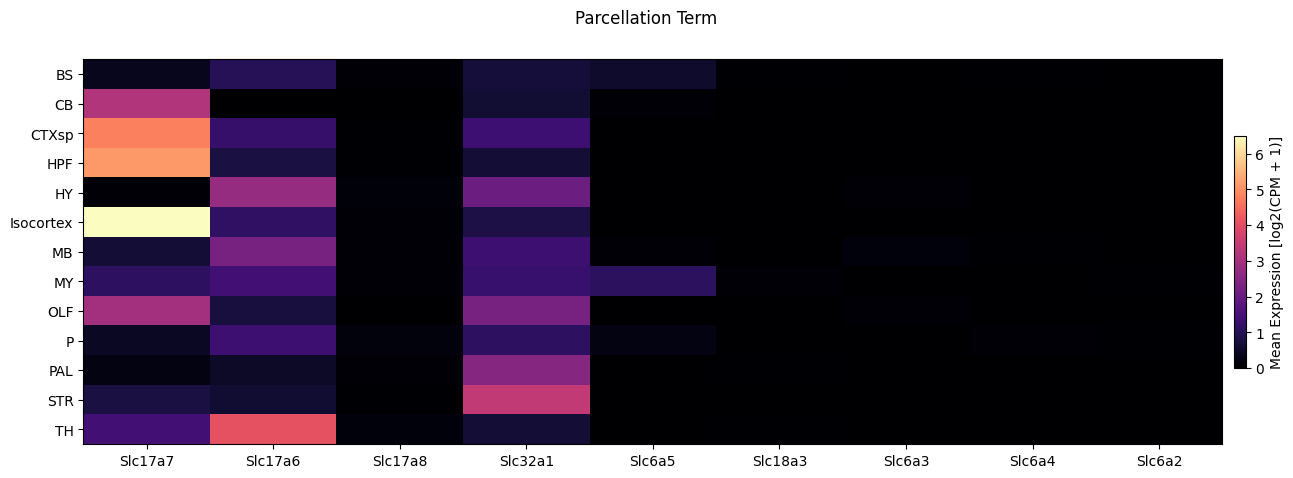

In [15]:
fig, ax = plot_heatmap(
    df=pd.concat([wmb_cell_extended, macosko_cell_extended]),
    gnames=gene_names,
    value='parcellation_term_symbol',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('Parcellation Term')
plt.show()

## Expression in the UMAP

Finally, we load the UMAP coordinates for our cells and plot the expression in the UMAP for each of our selected genes.

In [16]:
cell_2d_embedding_coordinates = value_sets = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-taxonomy',
    file_name='cell_2d_embedding_coordinates'
).set_index('cell_label')
cell_2d_embedding_coordinates.head()

x         y
cell_label                                   
GCGAGAAGTTAAGGGC-410_B05  16.037980  3.101109
AATGGCTCAGCTCCTT-411_B06  15.951514  3.144049
AACACACGTTGCTTGA-410_B05  15.900673  3.124507
CACAGATAGAGGCGGA-410_A05  16.062553  3.185574
GATCGTATCGAATCCA-411_B06  15.971468  3.124298

In [18]:
consensus_extended = pd.concat([wmb_cell_extended, macosko_cell_extended]).join(
    cell_2d_embedding_coordinates
).sample(frac=1)
consensus_extended.head()

cell_barcode  \
cell_label                                                        
TGCGTGGCATCTCCCA-020_D01                       TGCGTGGCATCTCCCA   
AGCAGCCAGCCACGTC-053_B01                       AGCAGCCAGCCACGTC   
pBICCNsMMrHY5iF022d210621E1_TACAGGTGTTGTGCAT   TACAGGTGTTGTGCAT   
pBICCNsMMrCBDECiM006d190313c_CACGTGGCAGTTGTCA  CACGTGGCAGTTGTCA   
pBICCNsMMrCBCOPiF002d190304a_GCACGTGAGCATTTGC  GCACGTGAGCATTTGC   

                                              barcoded_cell_sample_label  \
cell_label                                                                 
TGCGTGGCATCTCCCA-020_D01                                         020_D01   
AGCAGCCAGCCACGTC-053_B01                                         053_B01   
pBICCNsMMrHY5iF022d210621E1_TACAGGTGTTGTGCAT                         NaN   
pBICCNsMMrCBDECiM006d190313c_CACGTGGCAGTTGTCA                        NaN   
pBICCNsMMrCBCOPiF002d190304a_GCACGTGAGCATTTGC                        NaN   

                                                              library_label  \
cell_label                                                                    
TGCGTGGCATCTCCCA-020_D01                                 L8TX_180406_01_B02   
AGCAGCCAGCCACGTC-053_B01                                 L8TX_180926_01_E01   
pBICCNsMMrHY5iF022d210621E1_TACAGGTGTTGTGCAT    pBICCNsMMrHY5iF022d210621E1   
pBICCNsMMrCBDECiM006d190313c_CACGTGGCAGTTGTCA  pBICCNsMMrCBDECiM006d190313c   
pBICCNsMMrCBCOPiF002d190304a_GCACGTGAGCATTTGC  pBICCNsMMrCBCOPiF002d190304a   

                                                             dataset_label  \
cell_label                                                                   
TGCGTGGCATCTCCCA-020_D01                                         WMB-10Xv2   
AGCAGCCAGCCACGTC-053_B01                                         WMB-10Xv2   
pBICCNsMMrHY5iF022d210621E1_TACAGGTGTTGTGCAT   Consensus-Mouse-Macosko-10X   
pBICCNsMMrCBDECiM006d190313c_CACGTGGCAGTTGTCA  Consensus-Mouse-Macosko-10X   
pBICCNsMMrCBCOPiF002d190304a_GCACGTGAGCATTTGC  Consensus-Mouse-Macosko-10X   

                                                feature_matrix_label  \
cell_label                                                             
TGCGTGGCATCTCCCA-020_D01                               WMB-10Xv2-HPF   
AGCAGCCAGCCACGTC-053_B01                       WMB-10Xv2-Isocortex-2   
pBICCNsMMrHY5iF022d210621E1_TACAGGTGTTGTGCAT          Macosko-10X-HY   
pBICCNsMMrCBDECiM006d190313c_CACGTGGCAGTTGTCA         Macosko-10X-CB   
pBICCNsMMrCBCOPiF002d190304a_GCACGTGAGCATTTGC         Macosko-10X-CB   

                                               cluster_alias  \
cell_label                                                     
TGCGTGGCATCTCCCA-020_D01                               15568   
AGCAGCCAGCCACGTC-053_B01                               16341   
pBICCNsMMrHY5iF022d210621E1_TACAGGTGTTGTGCAT            7167   
pBICCNsMMrCBDECiM006d190313c_CACGTGGCAGTTGTCA          11833   
pBICCNsMMrCBCOPiF002d190304a_GCACGTGAGCATTTGC          11833   

                                                          class  \
cell_label                                                        
TGCGTGGCATCTCCCA-020_D01                         001 IT-ET Glut   
AGCAGCCAGCCACGTC-053_B01                         001 IT-ET Glut   
pBICCNsMMrHY5iF022d210621E1_TACAGGTGTTGTGCAT   013 HY GABA Glut   
pBICCNsMMrCBDECiM006d190313c_CACGTGGCAGTTGTCA    034 CB-CN Glut   
pBICCNsMMrCBCOPiF002d190304a_GCACGTGAGCATTTGC    034 CB-CN Glut   

                                                                cluster  \
cell_label                                                                
TGCGTGGCATCTCCCA-020_D01                           0442 CA1-ProS_Glut 4   
AGCAGCCAGCCACGTC-053_B01                        0021 L2/3-IT-CTX_Glut 3   
pBICCNsMMrHY5iF022d210621E1_TACAGGTGTTGTGCAT   2072 DMH-LHA_Gsx1_Gaba 1   
pBICCNsMMrCBDECiM006d190313c_CACGTGGCAGTTGTCA    6498 CB_Granule_Glut 2   
pBICCNsMMrCBCOPiF002d190304a_GCACGTGAGCATTTGC    6498 CB_Granule_Glut 2  

In [19]:
def plot_umap(
        df: pd.DataFrame,
        feature: str,
        cmap=None,
        vmin: Optional[float] = None,
        vmax: Optional[float] = None,
        fig_width=12,
        fig_height=12
):
    """Plot UMAP scatter plots for a given feature across multiple species.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell metadata including 'x', 'y', and 'species_genus' columns.
    feature : str
        Column name in df to color the points by (e.g., gene expression).
    species_list : list
        List of species to include in the plot.
    cmap : matplotlib colormap, optional
        Colormap to use for coloring the points. If None, uses the feature values as colors directly.
    vmin: float, optional
        Minimum value for color mapping. Defaults to min of values in the feature column. Cells with
        expression below this value will be plotted as light grey.
    vmax: float, optional
        Maximum value for color mapping. Defaults to max of values in the feature column.  Cells with
        expression above this value will be plotted as light grey.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
        

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the UMAP plots.
    ax : array of matplotlib.axes.Axes
        The axes objects for each species.
    """

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_width, fig_height)

    all_xx = df['x']
    all_yy = df['y']

    vv = df[feature]
    if vmin is None:
        vmin = vv.min()

    if vmax is None:
        vmax = vv.max()

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    xx = df['x']
    yy = df['y']
    vv = df[feature]

    if cmap is not None:
        mask = np.logical_and(vv >= vmin, vv <= vmax)
        if mask.any():
            ax.scatter(xx[~mask], yy[~mask], s=1.0, c='#D3D3D3', marker='.')
            ax.scatter(xx[mask], yy[mask], s=1.0, c=vv[mask], marker='.', cmap=cmap)
        else:
            ax.scatter(xx, yy, s=1.0, color=vv, marker=".")
    else :
        ax.scatter(xx, yy, s=1.0, color=vv, marker=".")

    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('[log2(CPM + 1)]')

    plt.legend(loc=0, markerscale=10)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

/tmp/ipykernel_10099/95516162.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0, markerscale=10)


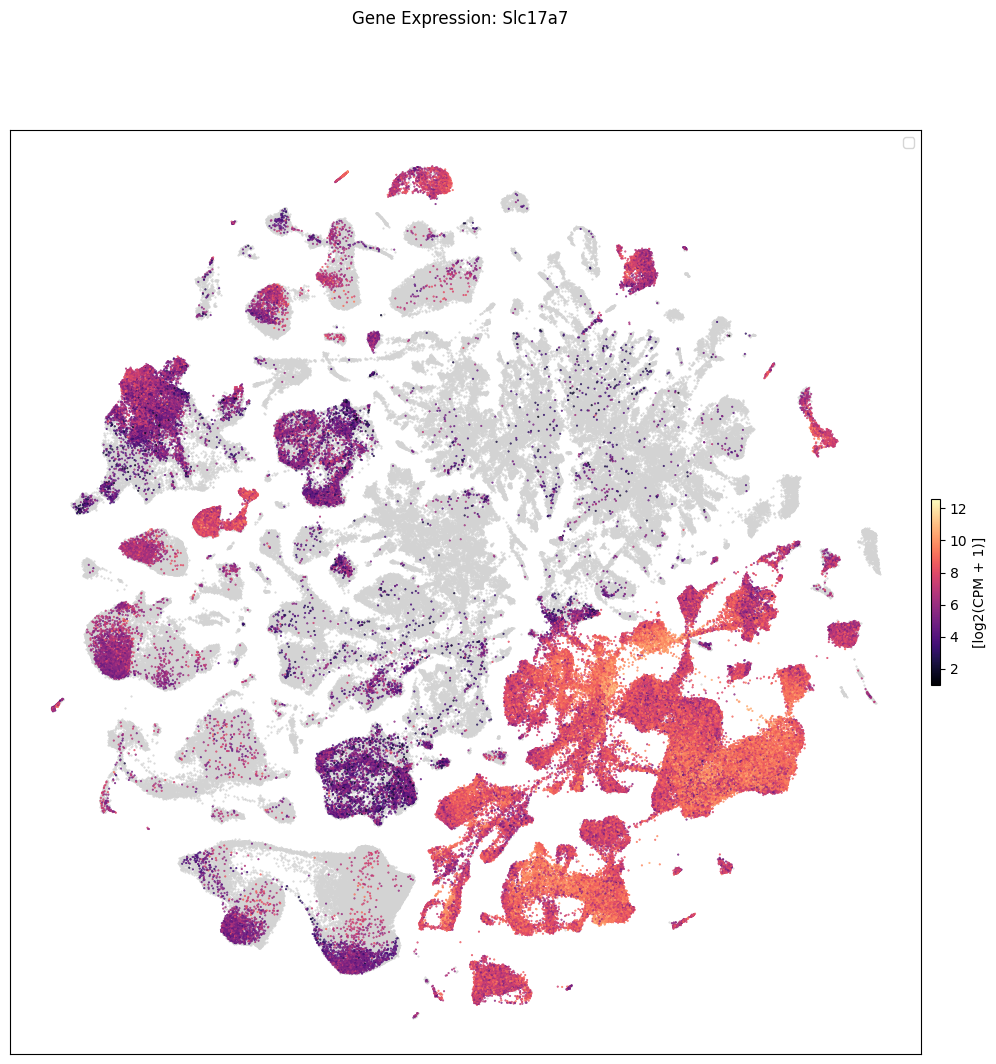

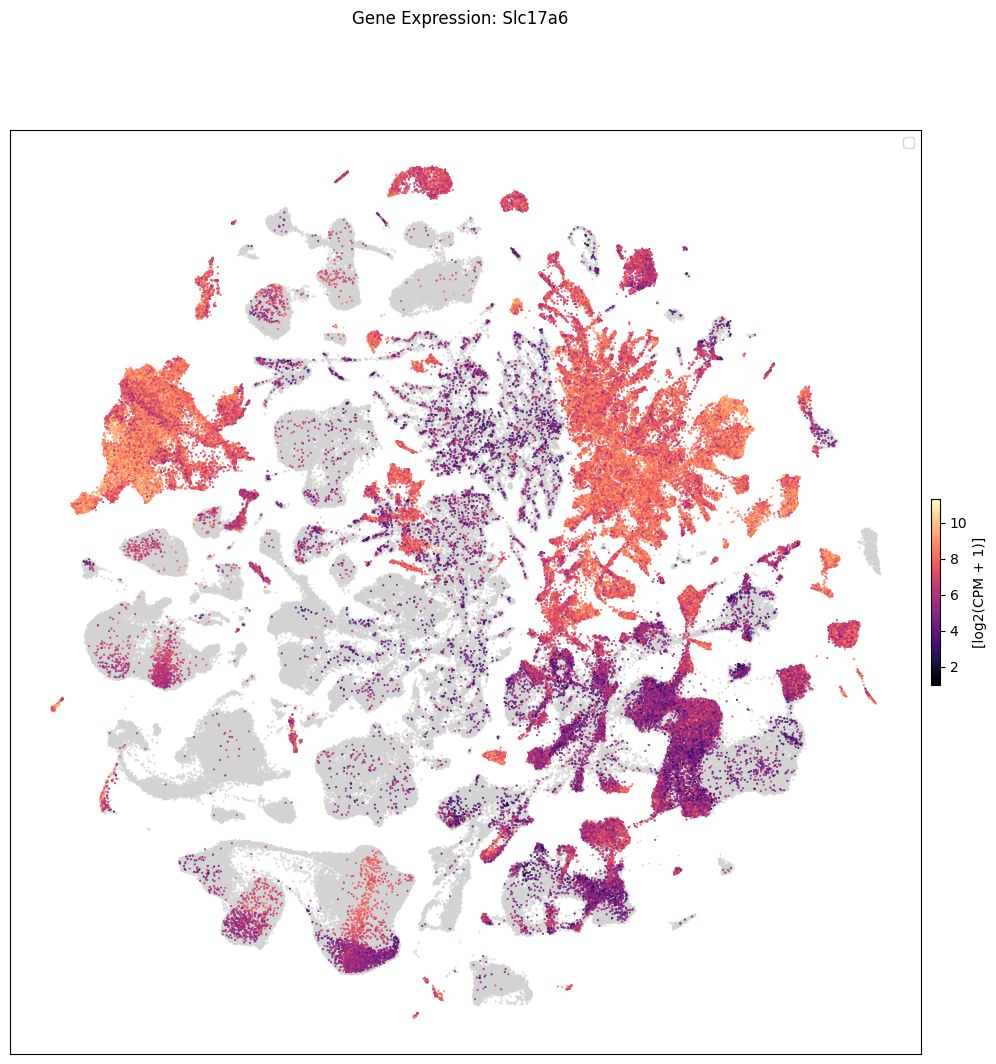

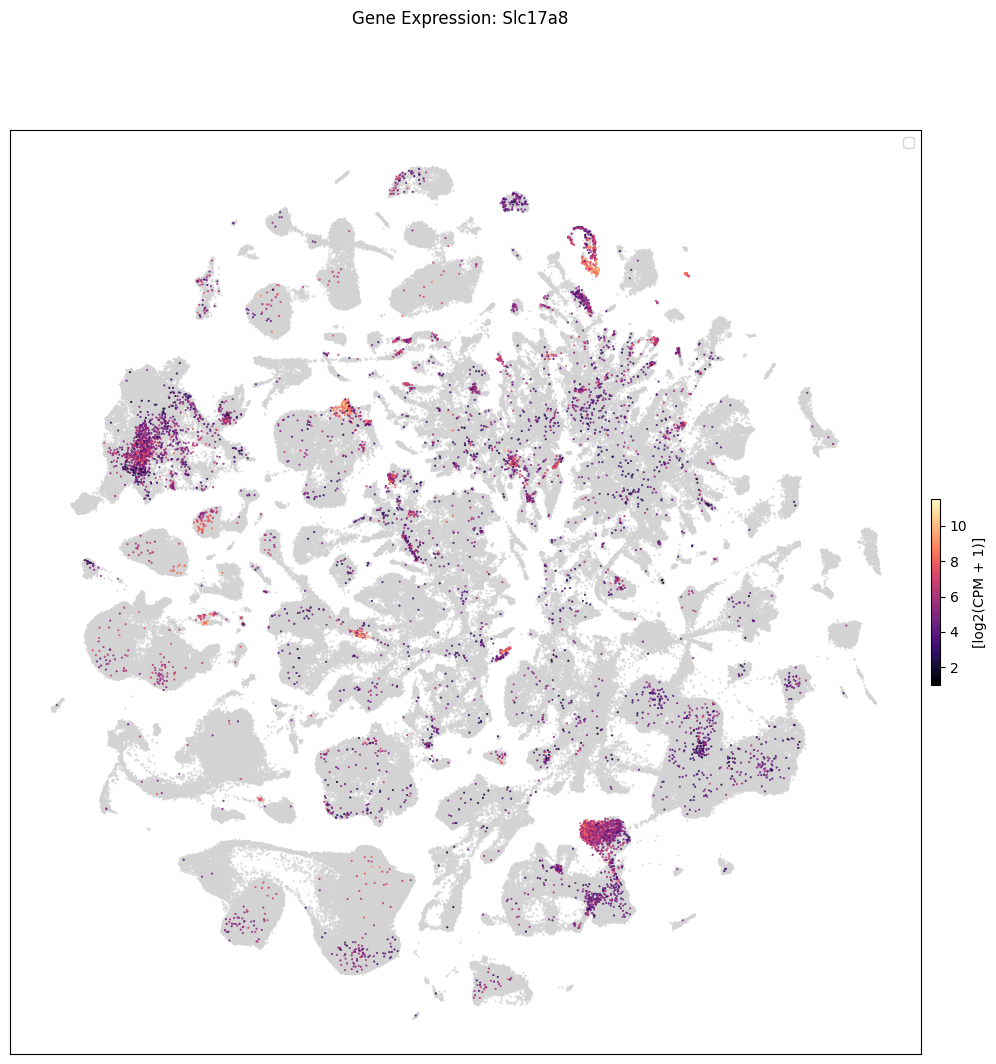

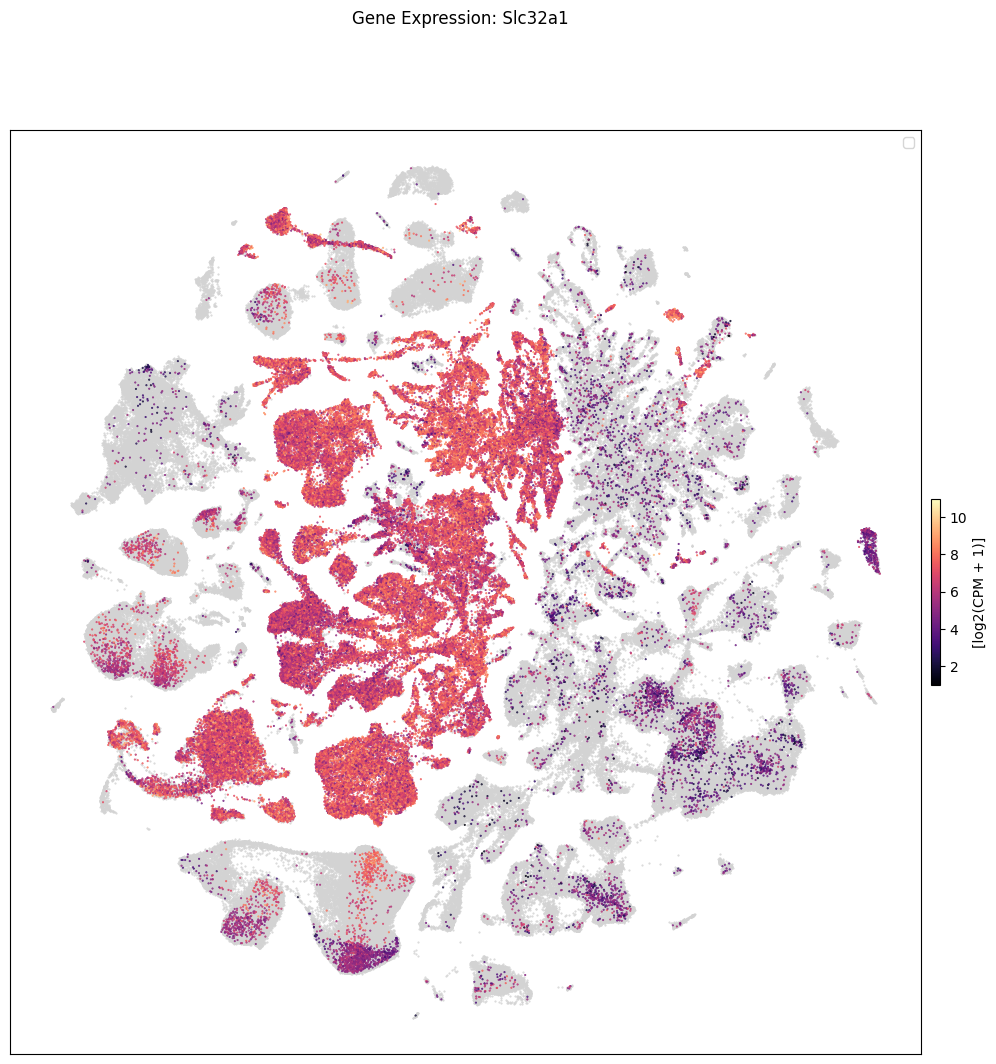

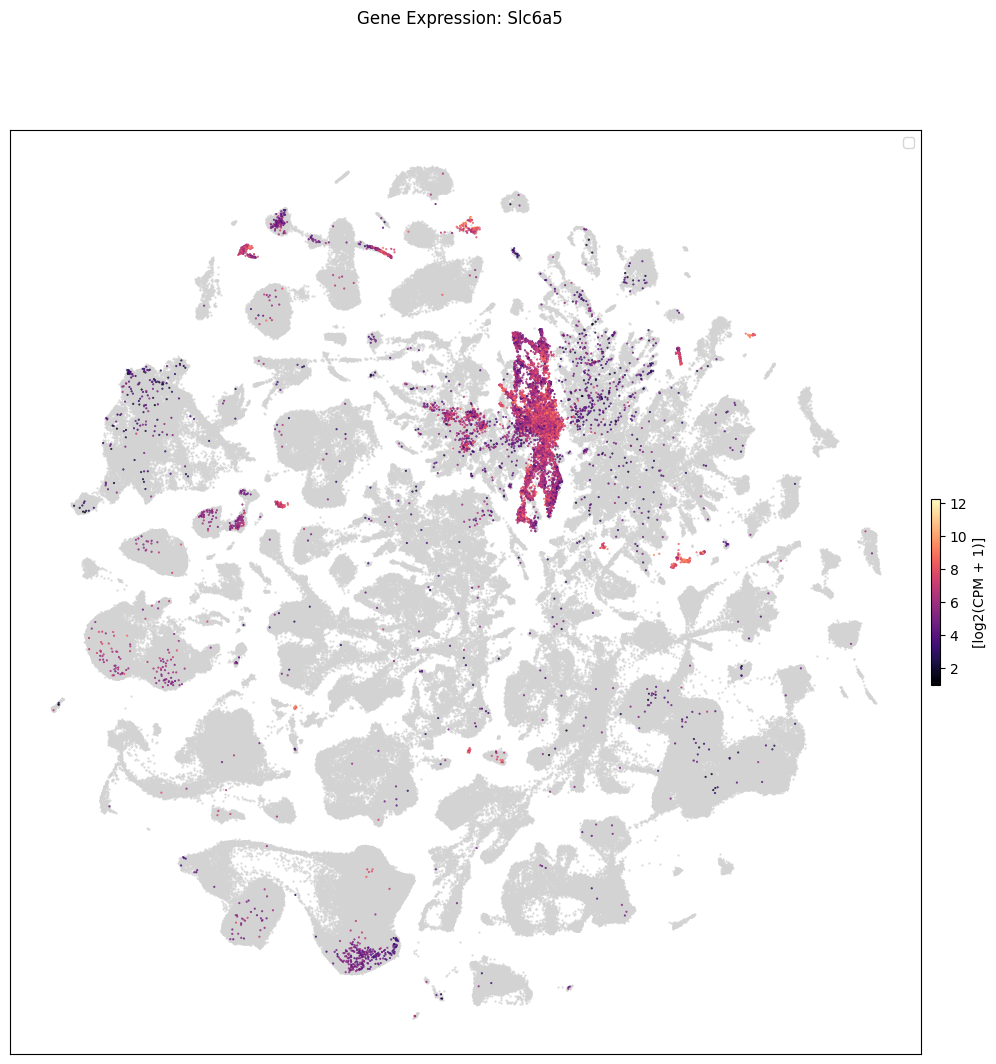

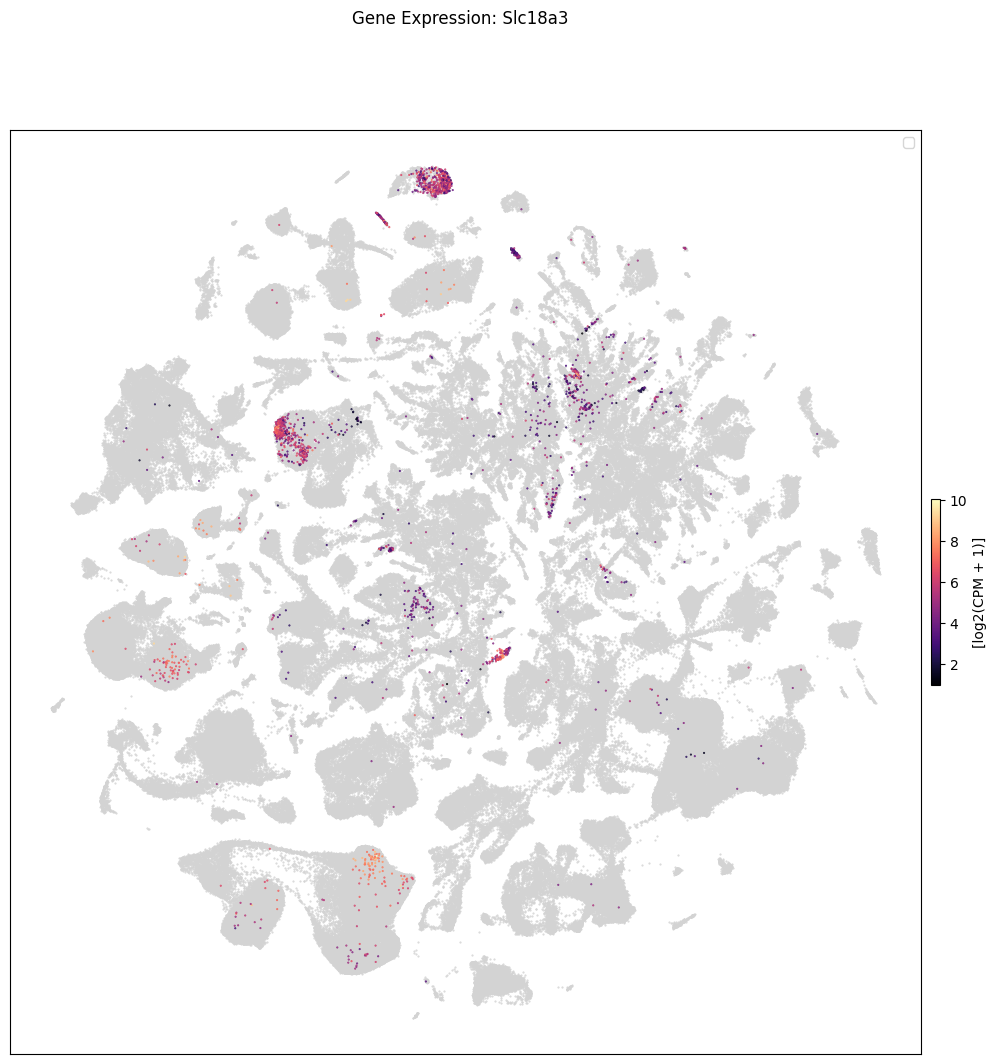

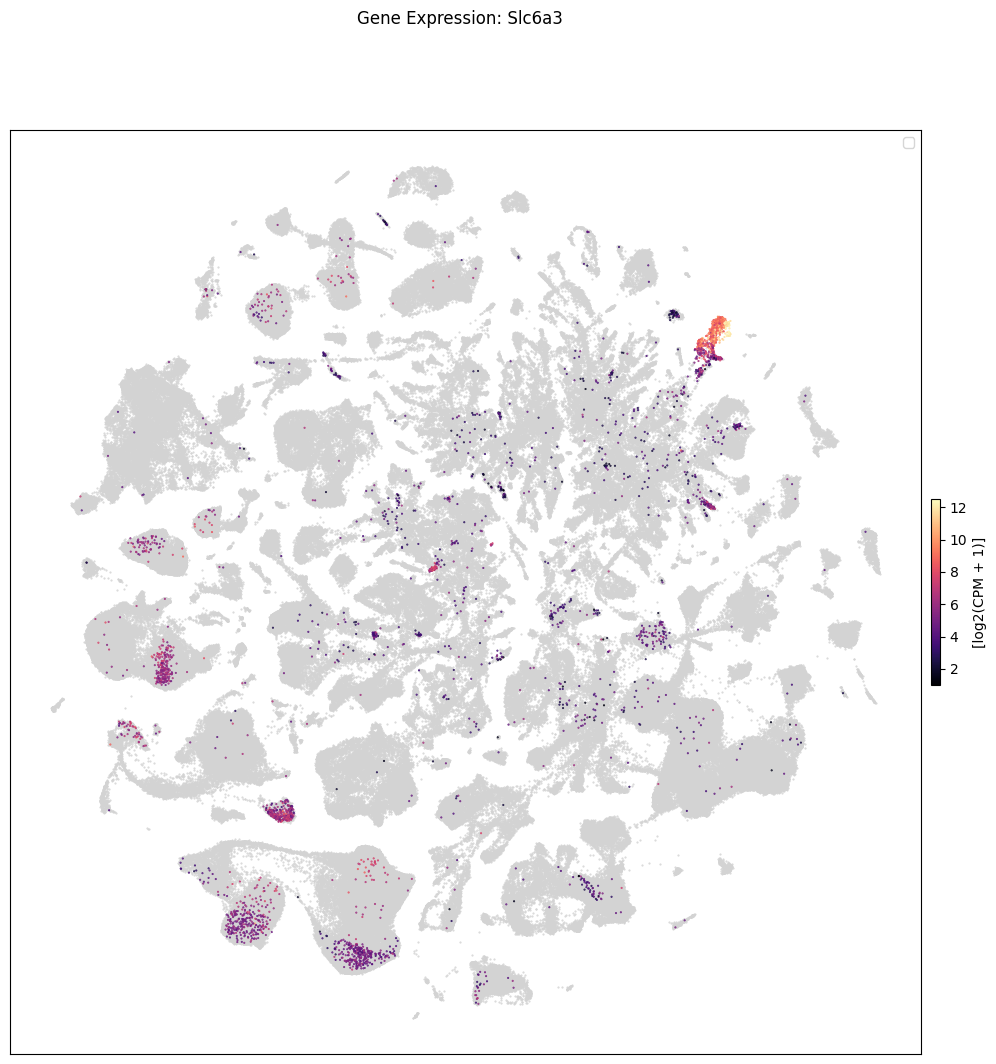

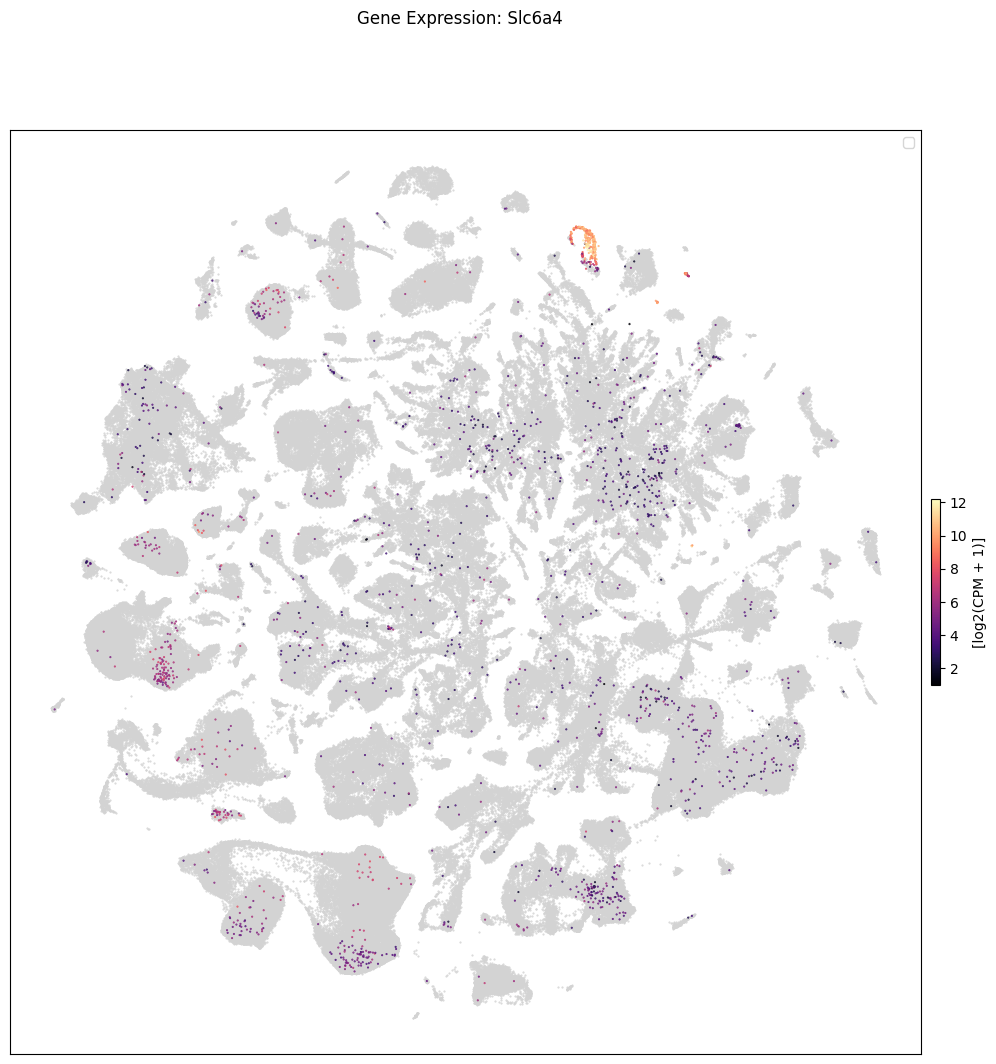

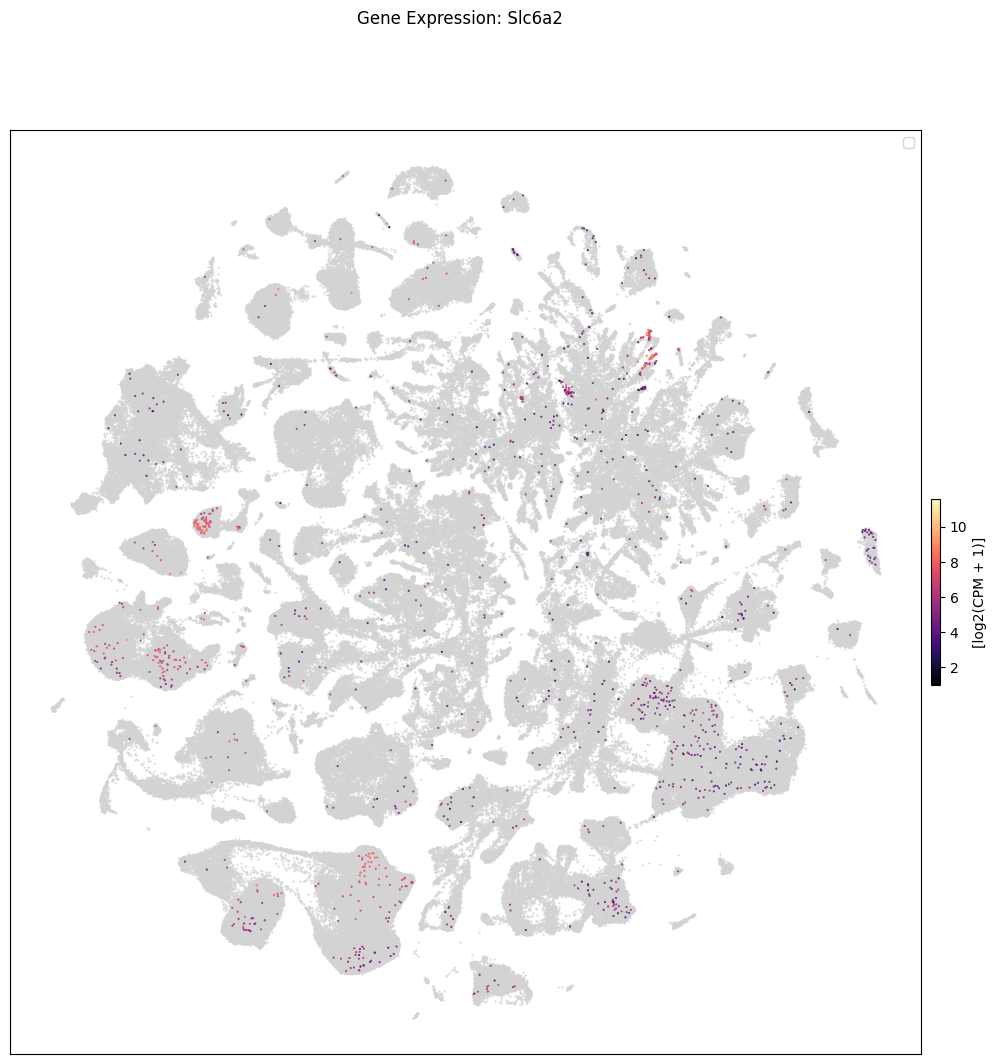

In [20]:
for gene_name in gene_names:
    fig, ax = plot_umap(
        consensus_extended[::10],
        feature=gene_name,
        cmap=plt.cm.magma,
        vmin=1,
        vmax=None,
        
    )
    fig.suptitle(f'Gene Expression: {gene_name}')
    plt.show()

Check out the previous exploration of the taxonomy and clustering annotations [here](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html). The notebooks for the AIBS, Whole Mouse Brain dataset can be found [here](https://alleninstitute.github.io/abc_atlas_access/descriptions/notebook_subtitle1.html).